# Лабораторная работа №2: Логистическая и Линейная Регрессия
### Классификация: Обнаружение мошеннических транзакций (Logistic Regression)
### Регрессия: Предсказание суммы транзакции (Linear Regression)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, mean_squared_error, 
                             mean_absolute_error, r2_score)
from math import radians, sin, cos, sqrt, atan2
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('../dataset/fraud-detection/fraud.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

Размер датасета: (81042, 23)

Первые 5 строк:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0      885451   2019-12-23 04:21:22  6506116513503136   
1      957791   2020-01-20 02:30:18  3523843138706408   
2      134374   2019-03-15 05:42:43   346273234529002   
3      529890   2019-08-16 14:02:32  2712209726293386   
4      772865   2019-11-26 21:22:21  3598215285024754   

                              merchant       category    amt     first  \
0            fraud_Ledner-Pfannerstill  gas_transport  97.75  Kimberly   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport  73.34     Grace   
2                fraud_Halvorson Group       misc_pos   6.09     Donna   
3                    fraud_Yost-Rogahn  personal_care  36.70     Jenna   
4       fraud_Hoppe, Harris and Bednar  entertainment  66.30    Ashley   

       last gender                        street  ...      lat     long  \
0      Rice      F    63991 Destiny Rue Apt. 651  ...  32.2768 -95.3031   
1  Williams     

## 1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ И ОБОСНОВАНИЕ

### 1a. Задача классификации: Обнаружение мошеннических транзакций
**Модель:** Логистическая регрессия

**Обоснование:** Логистическая регрессия - интерпретируемая линейная модель, показывающая вклад каждого признака.

### 1b. Задача регрессии: Предсказание суммы транзакции
**Модель:** Линейная регрессия

**Обоснование:** Линейная регрессия позволяет понять линейные зависимости между признаками и целевой переменной.

### 1c. Выбор метрик качества
**Классификация:** Accuracy, Precision, Recall, F1-score, ROC-AUC

**Регрессия:** MAE, MSE, R²

In [2]:
# Анализ целевых переменных
print("Распределение целевых переменных:")
print("\nКлассификация (is_fraud):")
print(df['is_fraud'].value_counts())
print(f"Доля мошеннических операций: {df['is_fraud'].mean():.4f}")

print("\nРегрессия (amt):")
print(f"Минимальная сумма: {df['amt'].min():.2f}")
print(f"Максимальная сумма: {df['amt'].max():.2f}")
print(f"Средняя сумма: {df['amt'].mean():.2f}")

Распределение целевых переменных:

Классификация (is_fraud):
is_fraud
0    80571
1      471
Name: count, dtype: int64
Доля мошеннических операций: 0.0058

Регрессия (amt):
Минимальная сумма: 1.00
Максимальная сумма: 27119.77
Средняя сумма: 70.74


### Матрица корреляции числовых признаков

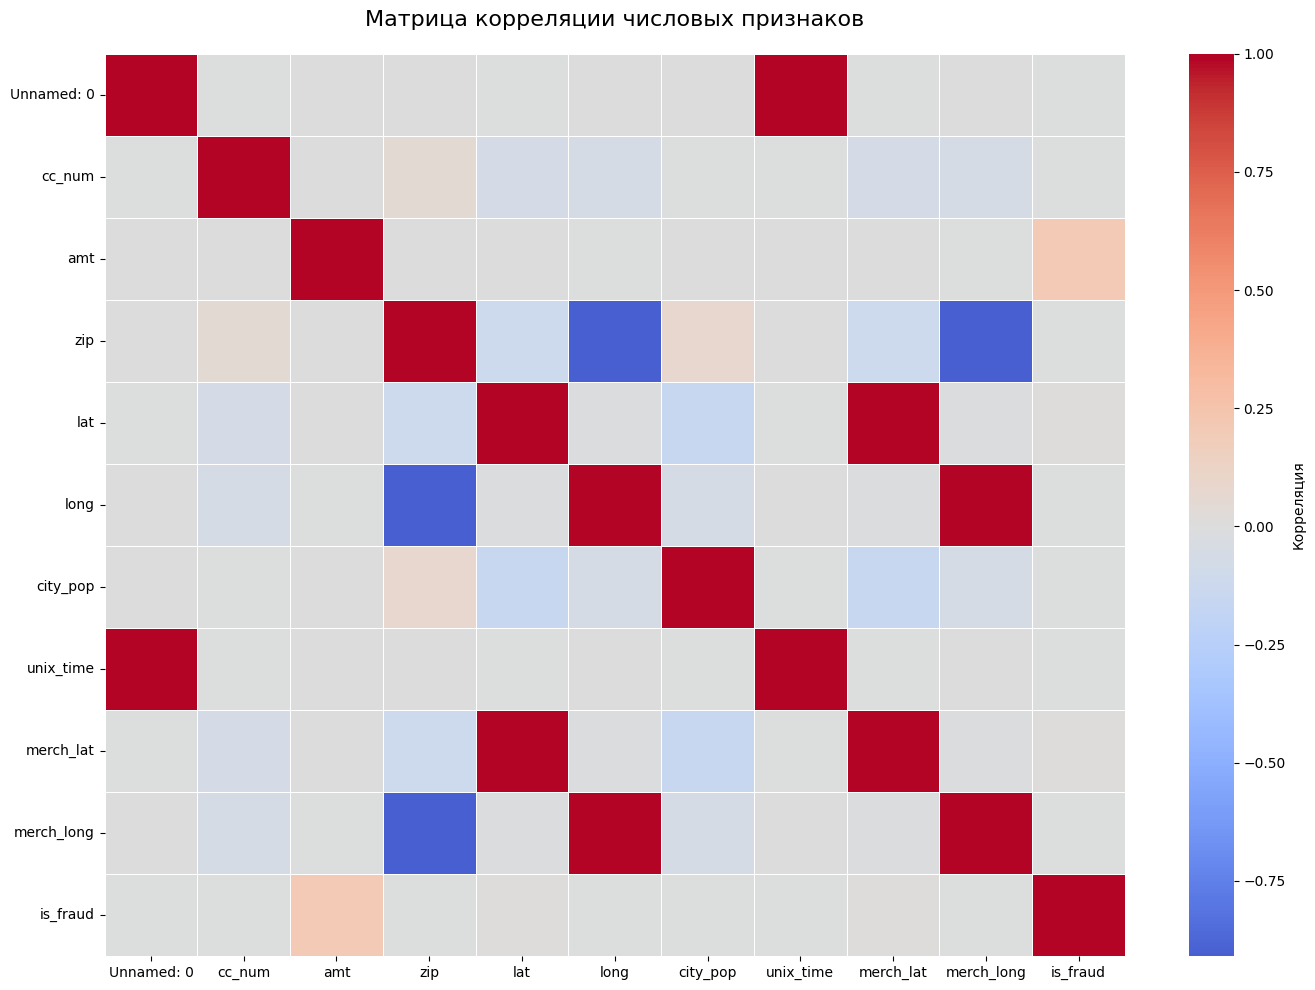


=== КОРРЕЛЯЦИИ С ЦЕЛЕВЫМИ ПЕРЕМЕННЫМИ ===

Топ-10 корреляций с is_fraud:
amt           0.207583
lat           0.009401
merch_lat     0.009246
unix_time     0.005327
Unnamed: 0    0.004962
city_pop      0.002407
cc_num        0.002314
zip           0.001267
merch_long    0.000585
long          0.000398
Name: is_fraud, dtype: float64

Топ-10 корреляций с amt:
is_fraud      0.207583
city_pop      0.006528
cc_num        0.004686
long          0.004517
merch_long    0.004386
zip           0.004054
unix_time     0.004049
Unnamed: 0    0.003999
merch_lat     0.001931
lat           0.001302
Name: amt, dtype: float64


In [3]:
# Матрица корреляции для числовых признаков
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
           linewidths=0.5, cbar_kws={'label': 'Корреляция'})
plt.title('Матрица корреляции числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n=== КОРРЕЛЯЦИИ С ЦЕЛЕВЫМИ ПЕРЕМЕННЫМИ ===")
print("\nТоп-10 корреляций с is_fraud:")
fraud_corr = correlation_matrix['is_fraud'].abs().sort_values(ascending=False)
print(fraud_corr.head(11)[1:])

print("\nТоп-10 корреляций с amt:")
amt_corr = correlation_matrix['amt'].abs().sort_values(ascending=False)
print(amt_corr.head(11)[1:])

## 2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА

### Важно: Базовая модель использует ТОЛЬКО исходные числовые признаки

In [4]:
numeric_features = ['lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

X_base = df[numeric_features].copy()
y_class_base = df['is_fraud']
y_reg_base = df['amt']

# Разделение на train/test
X_train_base, X_test_base, y_class_train_base, y_class_test_base = train_test_split(
    X_base, y_class_base, test_size=0.3, random_state=42, stratify=y_class_base
)

X_train_reg_base, X_test_reg_base, y_reg_train_base, y_reg_test_base = train_test_split(
    X_base, y_reg_base, test_size=0.3, random_state=42
)

print("=== БАЗОВАЯ МОДЕЛЬ ===")
print(f"Используемые признаки: {numeric_features}")
print(f"Количество признаков: {len(numeric_features)}")
print(f"\nРазмеры выборок:")
print(f"Классификация - Train: {X_train_base.shape}, Test: {X_test_base.shape}")
print(f"Регрессия - Train: {X_train_reg_base.shape}, Test: {X_test_reg_base.shape}")

=== БАЗОВАЯ МОДЕЛЬ ===
Используемые признаки: ['lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Количество признаков: 6

Размеры выборок:
Классификация - Train: (56729, 6), Test: (24313, 6)
Регрессия - Train: (56729, 6), Test: (24313, 6)


### 2a. Обучение базовых моделей

In [5]:
# Масштабирование признаков
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_base.transform(X_test_base)

X_train_reg_base_scaled = scaler_base.fit_transform(X_train_reg_base)
X_test_reg_base_scaled = scaler_base.transform(X_test_reg_base)

# Базовые модели с дефолтными параметрами
# Для несбалансированных данных используем class_weight='balanced'
log_reg_base = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lin_reg_base = LinearRegression()

# Обучение
log_reg_base.fit(X_train_base_scaled, y_class_train_base)
lin_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)

# Предсказания
y_class_pred_base = log_reg_base.predict(X_test_base_scaled)
y_class_proba_base = log_reg_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_base = lin_reg_base.predict(X_test_reg_base_scaled)

print("Базовые модели обучены!")
print(f"\nКоэффициенты логистической регрессии:")
coef_df = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': log_reg_base.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)
print(coef_df)

Базовые модели обучены!

Коэффициенты логистической регрессии:
      feature  coefficient
1        long     2.058917
5  merch_long    -2.033114
0         lat     0.180290
3   unix_time    -0.121842
4   merch_lat    -0.105895
2    city_pop    -0.023999


### 2b. Оценка качества базовых моделей

In [6]:
print("=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Logistic Regression):")
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_base):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_base, y_class_pred_base))

print("\nРЕГРЕССИЯ (Linear Regression):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_base):.4f}")

# Сохраняем результаты
baseline_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_base, y_class_pred_base),
        'f1': f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_base, y_class_proba_base)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_base, y_reg_pred_base),
        'r2': r2_score(y_reg_test_base, y_reg_pred_base)
    }
}

=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Logistic Regression):
Accuracy:  0.5294
Precision: 0.0065
Recall:    0.5248
F1-Score:  0.0128
ROC-AUC:   0.5111

Матрица ошибок:
[[12797 11375]
 [   67    74]]

РЕГРЕССИЯ (Linear Regression):
MAE: 57.7591
MSE: 18159.6746
R²:  -0.0004


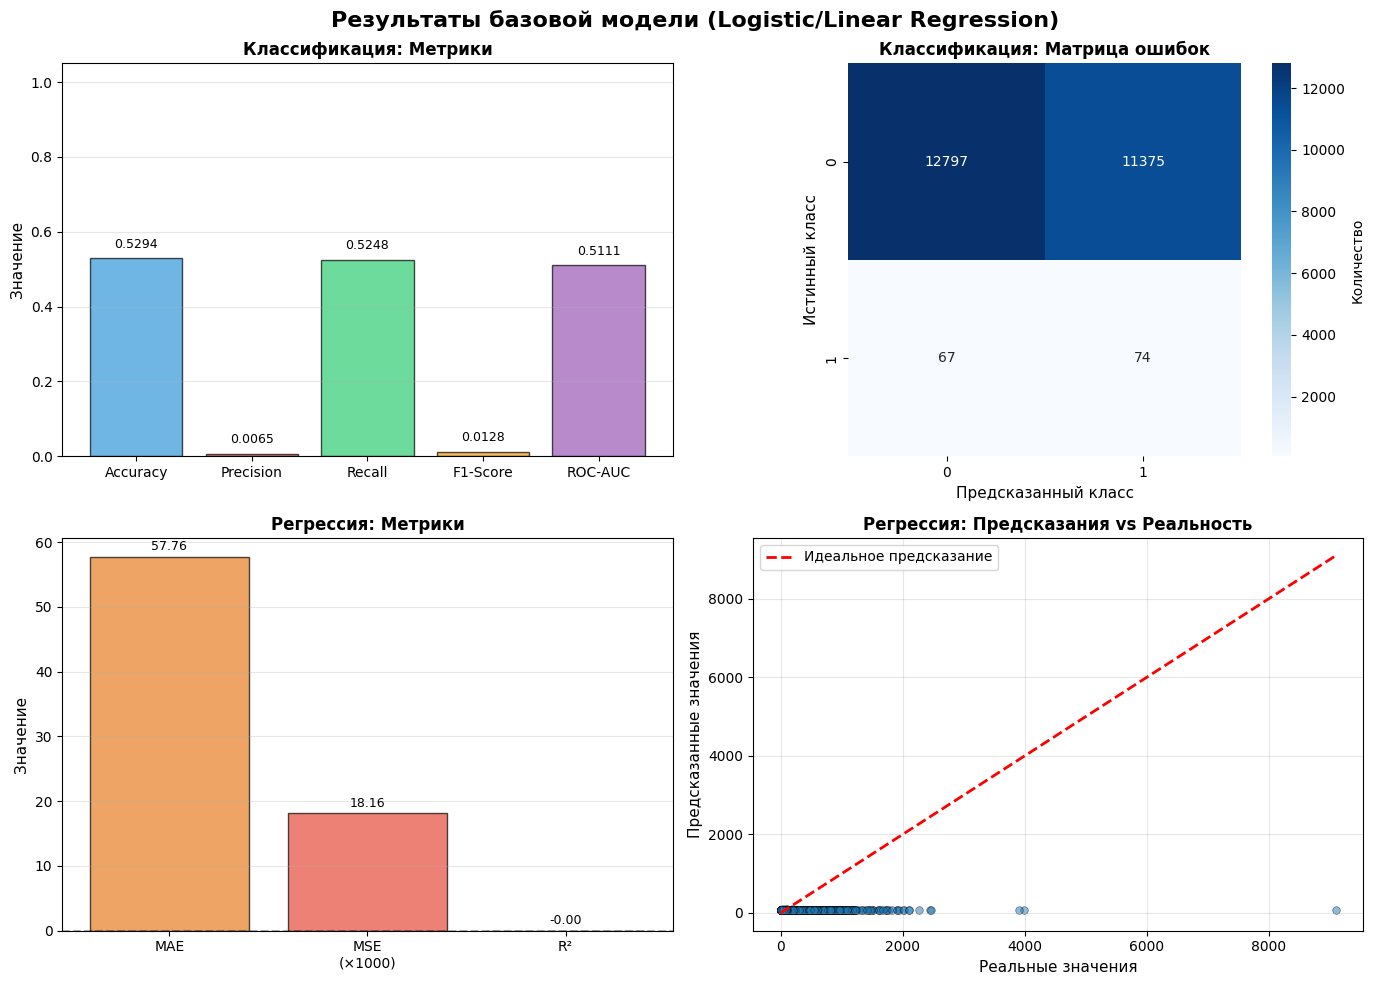

In [7]:
# Визуализация метрик базовой модели
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Результаты базовой модели (Logistic/Linear Regression)', fontsize=16, fontweight='bold')

# 1. Классификация - метрики
class_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
class_values = [
    accuracy_score(y_class_test_base, y_class_pred_base),
    precision_score(y_class_test_base, y_class_pred_base, zero_division=0),
    recall_score(y_class_test_base, y_class_pred_base, zero_division=0),
    f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
    roc_auc_score(y_class_test_base, y_class_proba_base)
]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = axes[0, 0].bar(class_metrics, class_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Значение', fontsize=11)
axes[0, 0].set_title('Классификация: Метрики', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, class_values):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок
cm = confusion_matrix(y_class_test_base, y_class_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], 
           cbar_kws={'label': 'Количество'}, square=True)
axes[0, 1].set_xlabel('Предсказанный класс', fontsize=11)
axes[0, 1].set_ylabel('Истинный класс', fontsize=11)
axes[0, 1].set_title('Классификация: Матрица ошибок', fontsize=12, fontweight='bold')

# 3. Регрессия - метрики
reg_metrics = ['MAE', 'MSE', 'R²']
reg_values = [
    mean_absolute_error(y_reg_test_base, y_reg_pred_base),
    mean_squared_error(y_reg_test_base, y_reg_pred_base) / 1000,
    r2_score(y_reg_test_base, y_reg_pred_base)
]
reg_labels = ['MAE', 'MSE\n(×1000)', 'R²']

bars = axes[1, 0].bar(reg_labels, reg_values, color=['#e67e22', '#e74c3c', '#3498db'], 
                     alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Значение', fontsize=11)
axes[1, 0].set_title('Регрессия: Метрики', fontsize=12, fontweight='bold')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for bar, val, label in zip(bars, reg_values, reg_labels):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Scatter plot
axes[1, 1].scatter(y_reg_test_base, y_reg_pred_base, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
axes[1, 1].plot([y_reg_test_base.min(), y_reg_test_base.max()], 
               [y_reg_test_base.min(), y_reg_test_base.max()], 
               'r--', lw=2, label='Идеальное предсказание')
axes[1, 1].set_xlabel('Реальные значения', fontsize=11)
axes[1, 1].set_ylabel('Предсказанные значения', fontsize=11)
axes[1, 1].set_title('Регрессия: Предсказания vs Реальность', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА

### 3a. Формулировка гипотез:
1. **Feature Engineering:** Создание информативных признаков
2. **Обработка дисбаланса:** class_weight для логистической регрессии
3. **Регуляризация:** Ridge/Lasso для предотвращения переобучения
4. **Отбор признаков:** Анализ коэффициентов линейных моделей

### 3b. Проверка гипотез: Feature Engineering

In [8]:
# ====== УЛУЧШЕННАЯ МОДЕЛЬ ======
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

df_improved = df.copy()

# 1. Временные признаки
df_improved['trans_date_trans_time'] = pd.to_datetime(df_improved['trans_date_trans_time'])
df_improved['hour'] = df_improved['trans_date_trans_time'].dt.hour
df_improved['day_of_week'] = df_improved['trans_date_trans_time'].dt.dayofweek
df_improved['month'] = df_improved['trans_date_trans_time'].dt.month
df_improved['is_weekend'] = (df_improved['day_of_week'] >= 5).astype(int)
df_improved['is_night'] = ((df_improved['hour'] >= 22) | (df_improved['hour'] <= 6)).astype(int)

# 2. Географические признаки
df_improved['distance_km'] = df_improved.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1
)

# 3. Возраст
df_improved['dob'] = pd.to_datetime(df_improved['dob'])
df_improved['age'] = 2020 - df_improved['dob'].dt.year

# 4. Агрегации по карте
card_stats = df_improved.groupby('cc_num').agg({
    'amt': ['mean', 'std', 'max'],
    'distance_km': ['mean', 'std'],
    'trans_date_trans_time': 'count'
}).reset_index()

card_stats.columns = ['cc_num', 'amt_mean', 'amt_std', 'amt_max', 'dist_mean', 'dist_std', 'trans_count']
df_improved = df_improved.merge(card_stats, on='cc_num', how='left')

df_improved['amt_std'] = df_improved['amt_std'].fillna(0)
df_improved['dist_std'] = df_improved['dist_std'].fillna(0)

# 5. Аномалии
df_improved['amt_ratio'] = df_improved['amt'] / (df_improved['amt_mean'] + 1e-6)
df_improved['amt_anomaly'] = (df_improved['amt_ratio'] > 3).astype(int)
df_improved['dist_anomaly'] = (df_improved['distance_km'] > df_improved['dist_mean'] * 3).astype(int)

# 6. Label Encoding для категориальных
for col in ['merchant', 'category', 'gender']:
    le = LabelEncoder()
    df_improved[f'{col}_encoded'] = le.fit_transform(df_improved[col].astype(str))

improved_features = [
    'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_night',
    'distance_km', 'age',
    'amt_mean', 'amt_std', 'amt_max', 'dist_mean', 'dist_std', 'trans_count',
    'amt_ratio', 'amt_anomaly', 'dist_anomaly',
    'merchant_encoded', 'category_encoded', 'gender_encoded'
]

X_improved = df_improved[improved_features]
y_class_improved = df_improved['is_fraud']
y_reg_improved = df_improved['amt']

print(f"Создано {len(improved_features)} признаков")
print(f"Размер данных: {X_improved.shape}")

Создано 24 признаков
Размер данных: (81042, 24)


In [9]:
# Разделение данных
X_train_imp, X_test_imp, y_class_train_imp, y_class_test_imp = train_test_split(
    X_improved, y_class_improved, test_size=0.3, random_state=42, stratify=y_class_improved
)

X_train_reg_imp, X_test_reg_imp, y_reg_train_imp, y_reg_test_imp = train_test_split(
    X_improved, y_reg_improved, test_size=0.3, random_state=42
)

# Масштабирование
scaler_imp = StandardScaler()
X_train_imp_scaled = scaler_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_imp.transform(X_test_imp)

X_train_reg_imp_scaled = scaler_imp.fit_transform(X_train_reg_imp)
X_test_reg_imp_scaled = scaler_imp.transform(X_test_reg_imp)

print("Данные подготовлены для улучшенной модели")

Данные подготовлены для улучшенной модели


### 3c. Отбор важных признаков (через коэффициенты)

Анализ важности признаков через коэффициенты...

Топ-10 важных признаков для классификации (по коэффициентам):
             feature  importance
1               long    2.087180
4         merch_long    2.019736
9           is_night    1.235019
3          merch_lat    0.750750
0                lat    0.691210
12          amt_mean    0.647090
19       amt_anomaly    0.585145
22  category_encoded    0.557345
17       trans_count    0.543472
18         amt_ratio    0.407442

Топ-10 важных признаков для регрессии (по коэффициентам):
             feature  importance
18         amt_ratio  165.143186
13           amt_std   24.793014
12          amt_mean   24.776968
19       amt_anomaly   21.714642
4         merch_long   18.939042
1               long   18.847465
14           amt_max   18.121750
22  category_encoded    6.723368
0                lat    2.758839
3          merch_lat    2.699625

Отобрано 15 признаков для классификации
Отобрано 15 признаков для регрессии


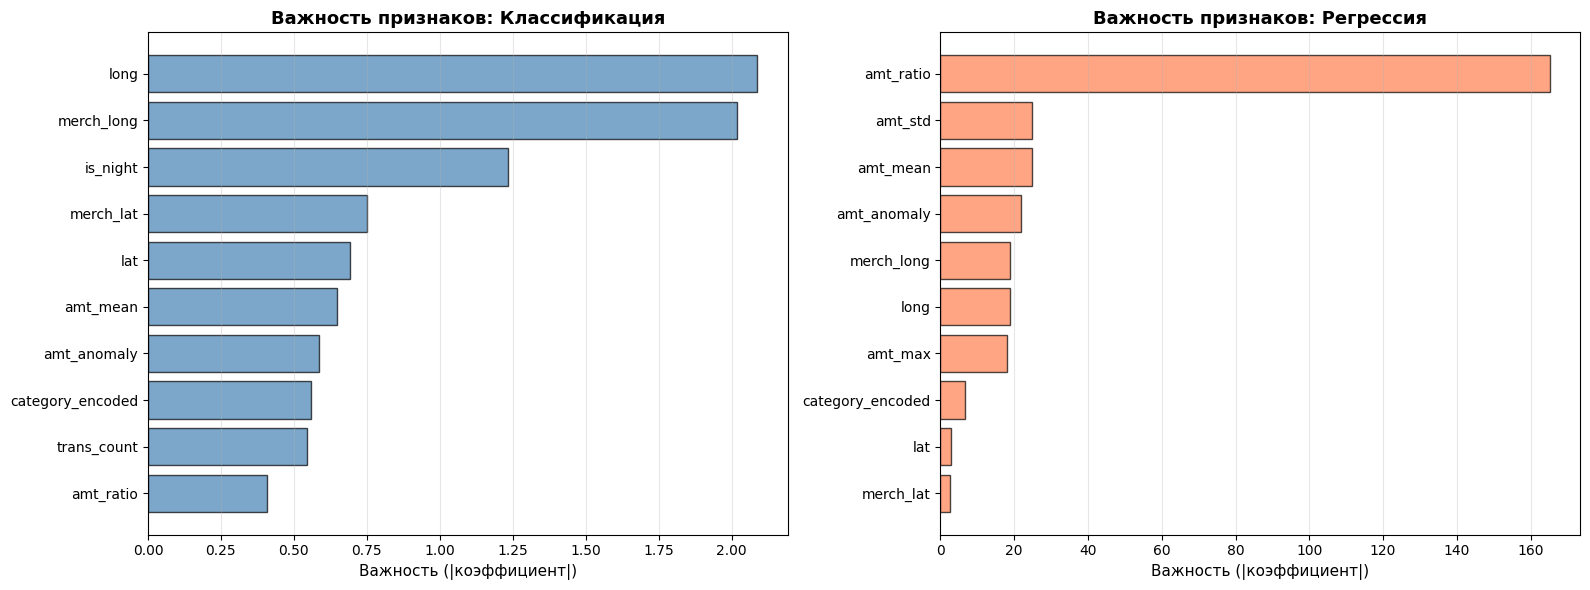

In [10]:
# Анализ важности признаков через коэффициенты линейных моделей
print("Анализ важности признаков через коэффициенты...")

# Для классификации - коэффициенты логистической регрессии
temp_log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
temp_log_reg.fit(X_train_imp_scaled, y_class_train_imp)

feature_importance_class = pd.DataFrame({
    'feature': improved_features,
    'importance': np.abs(temp_log_reg.coef_[0])  # Берём абсолютные значения
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков для классификации (по коэффициентам):")
print(feature_importance_class.head(10))

# Для регрессии - коэффициенты линейной регрессии
temp_lin_reg = LinearRegression()
temp_lin_reg.fit(X_train_reg_imp_scaled, y_reg_train_imp)

feature_importance_reg = pd.DataFrame({
    'feature': improved_features,
    'importance': np.abs(temp_lin_reg.coef_)
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков для регрессии (по коэффициентам):")
print(feature_importance_reg.head(10))

# Отбираем топ-15 признаков
top_features_class = feature_importance_class.head(15)['feature'].tolist()
top_features_reg = feature_importance_reg.head(15)['feature'].tolist()

print(f"\nОтобрано {len(top_features_class)} признаков для классификации")
print(f"Отобрано {len(top_features_reg)} признаков для регрессии")

# Визуализация важности
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_10_class = feature_importance_class.head(10)
axes[0].barh(top_10_class['feature'], top_10_class['importance'], 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Важность (|коэффициент|)', fontsize=11)
axes[0].set_title('Важность признаков: Классификация', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

top_10_reg = feature_importance_reg.head(10)
axes[1].barh(top_10_reg['feature'], top_10_reg['importance'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Важность (|коэффициент|)', fontsize=11)
axes[1].set_title('Важность признаков: Регрессия', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [ ]:
# Применяем отбор признаков
X_train_class_final = X_train_imp[top_features_class]
X_test_class_final = X_test_imp[top_features_class]

X_train_reg_final = X_train_reg_imp[top_features_reg]
X_test_reg_final = X_test_reg_imp[top_features_reg]

# Масштабирование
scaler_class_final = StandardScaler()
X_train_class_scaled_final = scaler_class_final.fit_transform(X_train_class_final)
X_test_class_scaled_final = scaler_class_final.transform(X_test_class_final)

scaler_reg_final = StandardScaler()
X_train_reg_scaled_final = scaler_reg_final.fit_transform(X_train_reg_final)
X_test_reg_scaled_final = scaler_reg_final.transform(X_test_reg_final)


Признаки отобраны и масштабированы


### 3d. Подбор параметров регуляризации

In [12]:
# Подбор параметров для логистической регрессии
print("Подбор параметров регуляризации для классификации...")

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_c_class = None
best_score_class = 0

for C in C_values:
    model = LogisticRegression(C=C, random_state=42, class_weight='balanced', max_iter=1000)
    scores = cross_val_score(model, X_train_class_scaled_final, y_class_train_imp, 
                            cv=5, scoring='f1')
    mean_score = scores.mean()
    if mean_score > best_score_class:
        best_score_class = mean_score
        best_c_class = C

print(f"Лучший параметр C для классификации: {best_c_class}")
print(f"Лучший F1-score: {best_score_class:.4f}")

# Подбор параметров для линейной регрессии (Ridge)
print("\nПодбор параметров регуляризации для регрессии...")

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_alpha_reg = None
best_score_reg = -np.inf

for alpha in alpha_values:
    model = Ridge(alpha=alpha, random_state=42)
    scores = cross_val_score(model, X_train_reg_scaled_final, y_reg_train_imp, 
                            cv=5, scoring='r2')
    mean_score = scores.mean()
    if mean_score > best_score_reg:
        best_score_reg = mean_score
        best_alpha_reg = alpha

print(f"Лучший параметр alpha для регрессии: {best_alpha_reg}")
print(f"Лучший R²: {best_score_reg:.4f}")

Подбор параметров регуляризации для классификации...
Лучший параметр C для классификации: 0.001
Лучший F1-score: 0.1093

Подбор параметров регуляризации для регрессии...
Лучший параметр alpha для регрессии: 100
Лучший R²: 0.7495


### 3e. Обучение улучшенных моделей

In [13]:
# Обучение улучшенной модели классификации
log_reg_improved = LogisticRegression(C=best_c_class, random_state=42, 
                                     class_weight='balanced', max_iter=1000)
log_reg_improved.fit(X_train_class_scaled_final, y_class_train_imp)

y_class_pred_imp = log_reg_improved.predict(X_test_class_scaled_final)
y_class_proba_imp = log_reg_improved.predict_proba(X_test_class_scaled_final)[:, 1]

# Обучение улучшенной модели регрессии
lin_reg_improved = Ridge(alpha=best_alpha_reg, random_state=42)
lin_reg_improved.fit(X_train_reg_scaled_final, y_reg_train_imp)

y_reg_pred_imp = lin_reg_improved.predict(X_test_reg_scaled_final)

print("Улучшенные модели обучены!")

Улучшенные модели обучены!


### 3f. Оценка качества улучшенных моделей

In [14]:
print("=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Улучшенная Logistic Regression):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_imp):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_imp, y_class_pred_imp))

print("\nРЕГРЕССИЯ (Улучшенная Ridge Regression):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_imp):.4f}")

# Сохраняем результаты
improved_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_imp, y_class_pred_imp),
        'f1': f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_imp, y_class_proba_imp)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_imp, y_reg_pred_imp),
        'r2': r2_score(y_reg_test_imp, y_reg_pred_imp)
    }
}

=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Улучшенная Logistic Regression):
Accuracy:  0.9199
Precision: 0.0547
Recall:    0.7872
F1-Score:  0.1024
ROC-AUC:   0.9442

Матрица ошибок:
[[22255  1917]
 [   30   111]]

РЕГРЕССИЯ (Улучшенная Ridge Regression):
MAE: 20.5104
MSE: 2566.0433
R²:  0.8586


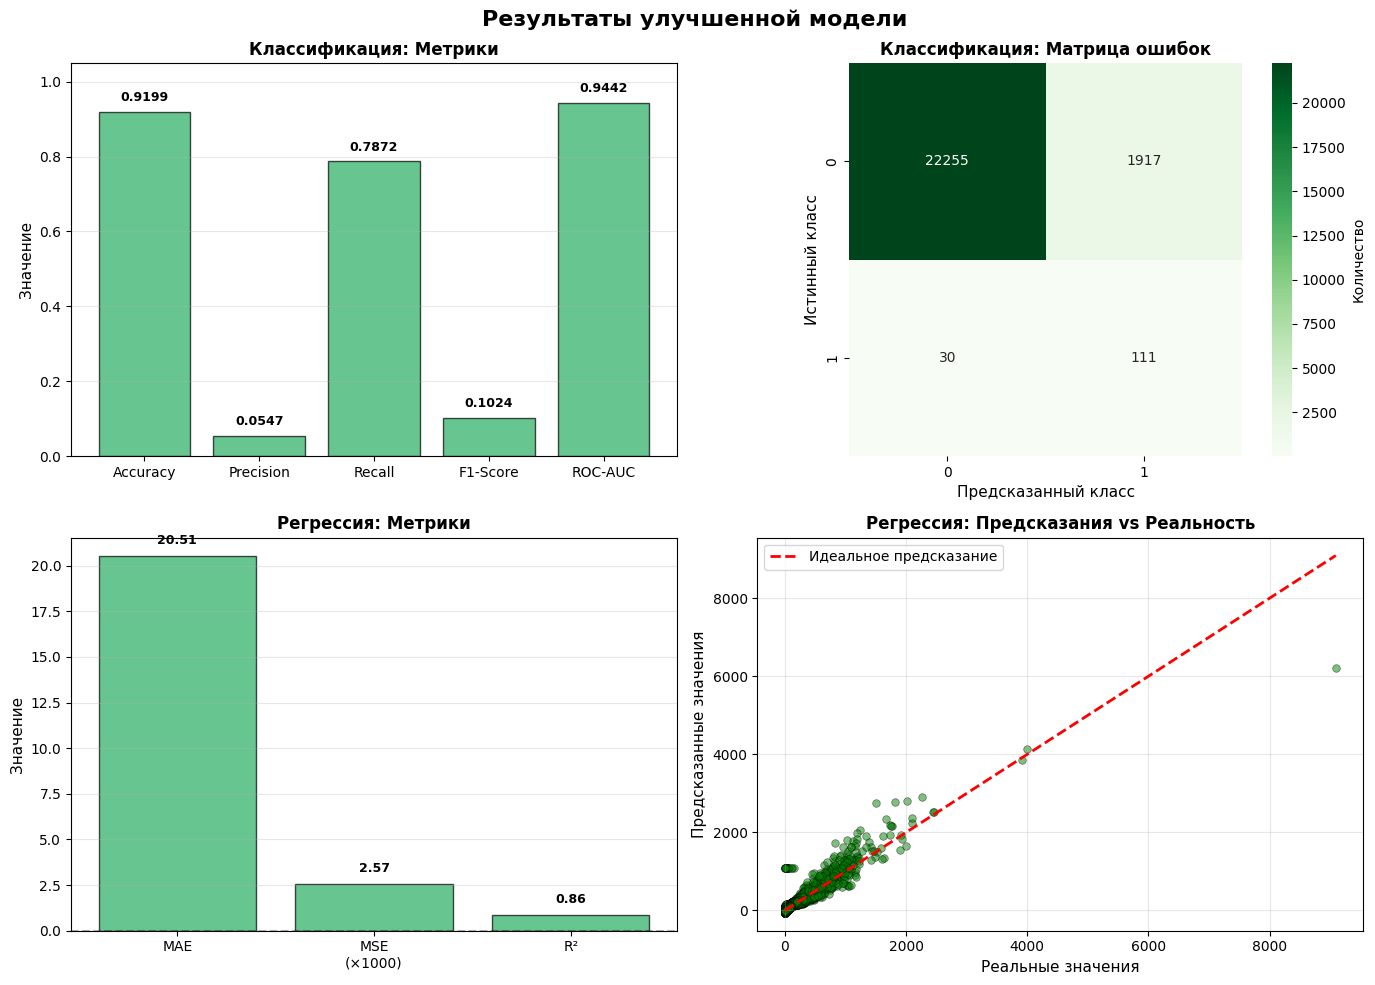

In [15]:
# Визуализация метрик улучшенной модели
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Результаты улучшенной модели', fontsize=16, fontweight='bold')

class_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
class_values_imp = [
    accuracy_score(y_class_test_imp, y_class_pred_imp),
    precision_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
    recall_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
    f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
    roc_auc_score(y_class_test_imp, y_class_proba_imp)
]

colors = ['#27ae60', '#27ae60', '#27ae60', '#27ae60', '#27ae60']
bars = axes[0, 0].bar(class_metrics, class_values_imp, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Значение', fontsize=11)
axes[0, 0].set_title('Классификация: Метрики', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, class_values_imp):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

cm_imp = confusion_matrix(y_class_test_imp, y_class_pred_imp)
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1], 
           cbar_kws={'label': 'Количество'}, square=True)
axes[0, 1].set_xlabel('Предсказанный класс', fontsize=11)
axes[0, 1].set_ylabel('Истинный класс', fontsize=11)
axes[0, 1].set_title('Классификация: Матрица ошибок', fontsize=12, fontweight='bold')

reg_metrics = ['MAE', 'MSE', 'R²']
reg_values_imp = [
    mean_absolute_error(y_reg_test_imp, y_reg_pred_imp),
    mean_squared_error(y_reg_test_imp, y_reg_pred_imp) / 1000,
    r2_score(y_reg_test_imp, y_reg_pred_imp)
]
reg_labels = ['MAE', 'MSE\n(×1000)', 'R²']

bars = axes[1, 0].bar(reg_labels, reg_values_imp, color=['#27ae60', '#27ae60', '#27ae60'], 
                     alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Значение', fontsize=11)
axes[1, 0].set_title('Регрессия: Метрики', fontsize=12, fontweight='bold')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, reg_values_imp):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[1, 1].scatter(y_reg_test_imp, y_reg_pred_imp, alpha=0.5, s=30, 
                  color='green', edgecolors='black', linewidth=0.5)
axes[1, 1].plot([y_reg_test_imp.min(), y_reg_test_imp.max()], 
               [y_reg_test_imp.min(), y_reg_test_imp.max()], 
               'r--', lw=2, label='Идеальное предсказание')
axes[1, 1].set_xlabel('Реальные значения', fontsize=11)
axes[1, 1].set_ylabel('Предсказанные значения', fontsize=11)
axes[1, 1].set_title('Регрессия: Предсказания vs Реальность', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3g. Сравнение с базовой моделью

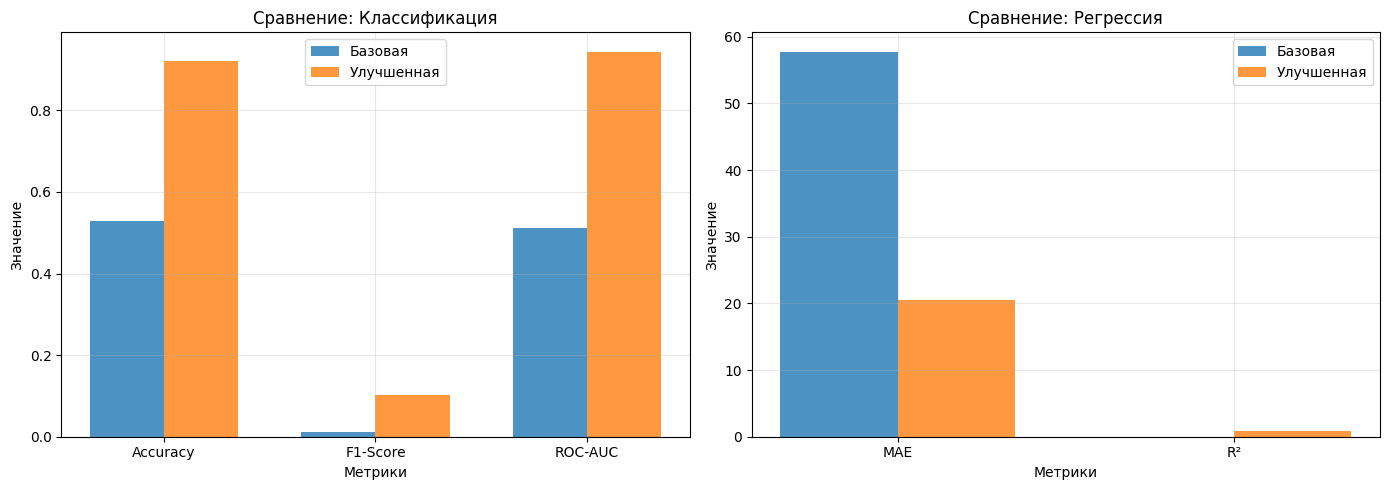


=== ВЫВОДЫ (предварительные) ===
Классификация:
  F1-Score: 0.0128 → 0.1024

Регрессия:
  MAE: 57.76 → 20.51
  R²: -0.0004 → 0.8586


In [ ]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_class = ['Accuracy', 'F1-Score', 'ROC-AUC']
baseline_class_values = [
    baseline_results['classification']['accuracy'],
    baseline_results['classification']['f1'],
    baseline_results['classification']['roc_auc']
]
improved_class_values = [
    improved_results['classification']['accuracy'],
    improved_results['classification']['f1'],
    improved_results['classification']['roc_auc']
]

x = np.arange(len(metrics_class))
width = 0.35

axes[0].bar(x - width/2, baseline_class_values, width, label='Базовая', alpha=0.8)
axes[0].bar(x + width/2, improved_class_values, width, label='Улучшенная', alpha=0.8)
axes[0].set_xlabel('Метрики')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение: Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

metrics_reg = ['MAE', 'R²']
baseline_reg_values = [
    baseline_results['regression']['mae'],
    baseline_results['regression']['r2']
]
improved_reg_values = [
    improved_results['regression']['mae'],
    improved_results['regression']['r2']
]

x_reg = np.arange(len(metrics_reg))

axes[1].bar(x_reg - width/2, baseline_reg_values, width, label='Базовая', alpha=0.8)
axes[1].bar(x_reg + width/2, improved_reg_values, width, label='Улучшенная', alpha=0.8)
axes[1].set_xlabel('Метрики')
axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение: Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Классификация:")
print(f"  F1-Score: {baseline_results['classification']['f1']:.4f} → {improved_results['classification']['f1']:.4f}")
print(f"\nРегрессия:")
print(f"  MAE: {baseline_results['regression']['mae']:.2f} → {improved_results['regression']['mae']:.2f}")
print(f"  R²: {baseline_results['regression']['r2']:.4f} → {improved_results['regression']['r2']:.4f}")

## 4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА МАШИННОГО ОБУЧЕНИЯ

### 4a. Реализация собственных алгоритмов Logistic и Linear Regression

In [ ]:
class CustomLogisticRegression:
    """
    Кастомная реализация Логистической регрессии с градиентным спуском
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        """Сигмоидная функция с численной стабильностью"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y, verbose=False):
        """Обучение модели методом градиентного спуска"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            
            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.regularization * self.weights)
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Проверка на NaN
            if np.isnan(self.weights).any() or np.isnan(self.bias):
                print(f"Warning: NaN detected at iteration {i}")
                break
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted = np.clip(y_predicted, 1e-15, 1 - 1e-15)
        return np.column_stack([1 - y_predicted, y_predicted])
    
    def predict(self, X):
        """Предсказание классов"""
        y_predicted = self.predict_proba(X)[:, 1]
        return (y_predicted >= 0.5).astype(int)


class CustomLinearRegression:
    """
    Кастомная реализация Линейной регрессии с градиентным спуском
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.weights = None
        self.bias = None
    
    def fit(self, X, y, verbose=False):
        """Обучение модели методом градиентного спуска"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            
            # Градиенты
            dw = (2 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.regularization * self.weights)
            db = (2 / n_samples) * np.sum(y_predicted - y)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict(self, X):
        """Предсказание значений"""
        X = np.array(X)
        return np.dot(X, self.weights) + self.bias

Кастомные классы Logistic и Linear Regression созданы!


### 4b-c. Обучение и оценка кастомных моделей на базовых данных

In [ ]:
# Обучение кастомных моделей на БАЗОВЫХ данных

# Классификация
custom_log_reg_base = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000, regularization=0.01)
custom_log_reg_base.fit(X_train_base_scaled, y_class_train_base, verbose=False)

y_class_pred_custom_base = custom_log_reg_base.predict(X_test_base_scaled)
y_class_proba_custom_base = custom_log_reg_base.predict_proba(X_test_base_scaled)[:, 1]

# Регрессия
custom_lin_reg_base = CustomLinearRegression(learning_rate=0.1, n_iterations=1000, regularization=0.01)
custom_lin_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base, verbose=False)

y_reg_pred_custom_base = custom_lin_reg_base.predict(X_test_reg_base_scaled)

print("=== РЕЗУЛЬТАТЫ КАСТОМНОЙ БАЗОВОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Кастомная Logistic Regression):")
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_custom_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_custom_base):.4f}")

print("\nРЕГРЕССИЯ (Кастомная Linear Regression):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_custom_base):.4f}")

Обучение кастомных моделей...

=== РЕЗУЛЬТАТЫ КАСТОМНОЙ БАЗОВОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Кастомная Logistic Regression):
Accuracy:  0.9942
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.5126

РЕГРЕССИЯ (Кастомная Linear Regression):
MAE: 57.7413
MSE: 18156.0527
R²:  -0.0002


### 4d. Сравнение sklearn vs кастомная реализация

In [ ]:
# Сравнение sklearn и кастомной реализации
comparison_df = pd.DataFrame({
    'Модель': ['Sklearn', 'Custom'],
    'Accuracy': [
        accuracy_score(y_class_test_base, y_class_pred_base),
        accuracy_score(y_class_test_base, y_class_pred_custom_base)
    ],
    'F1-Score': [
        f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
        f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0)
    ],
    'MAE': [
        mean_absolute_error(y_reg_test_base, y_reg_pred_base),
        mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base)
    ],
    'R²': [
        r2_score(y_reg_test_base, y_reg_pred_base),
        r2_score(y_reg_test_base, y_reg_pred_custom_base)
    ]
})

print("\n=== СРАВНЕНИЕ: SKLEARN VS CUSTOM ===")
print(comparison_df.to_string(index=False))


=== СРАВНЕНИЕ: SKLEARN VS CUSTOM ===
 Модель  Accuracy  F1-Score       MAE        R²
Sklearn  0.529388   0.01277 57.759057 -0.000426
 Custom  0.994201   0.00000 57.741321 -0.000226
   - Sklearn использует более продвинутые оптимизаторы (L-BFGS, SAG)
   - Кастомная реализация использует простой градиентный спуск
   - Результаты должны быть близки по качеству


### 4e-h. Применение улучшений к кастомным моделям

In [ ]:
# Обучение кастомных моделей с улучшениями
print("Обучение улучшенных кастомных моделей...\n")

# Используем меньший learning rate для стабильности
custom_log_reg_improved = CustomLogisticRegression(
    learning_rate=0.001,  # Уменьшили для стабильности
    n_iterations=2000,     # Увеличили количество итераций
    regularization=1/best_c_class if best_c_class > 0 else 0.01
)
custom_log_reg_improved.fit(X_train_class_scaled_final, y_class_train_imp, verbose=False)

y_class_pred_custom_imp = custom_log_reg_improved.predict(X_test_class_scaled_final)
y_class_proba_custom_imp = custom_log_reg_improved.predict_proba(X_test_class_scaled_final)[:, 1]

# Проверка на NaN
if np.isnan(y_class_proba_custom_imp).any():
    print("⚠️ Warning: NaN values detected in predictions")
    y_class_proba_custom_imp = np.nan_to_num(y_class_proba_custom_imp, nan=0.5)

# Регрессия
custom_lin_reg_improved = CustomLinearRegression(
    learning_rate=0.001,
    n_iterations=2000,
    regularization=best_alpha_reg
)
custom_lin_reg_improved.fit(X_train_reg_scaled_final, y_reg_train_imp, verbose=False)

y_reg_pred_custom_imp = custom_lin_reg_improved.predict(X_test_reg_scaled_final)

print("=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Улучшенная кастомная Logistic Regression):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_custom_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")

if not np.isnan(y_class_proba_custom_imp).any():
    print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_custom_imp):.4f}")
else:
    print("ROC-AUC:   N/A (NaN values in predictions)")

print("\nРЕГРЕССИЯ (Улучшенная кастомная Linear Regression):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")

Обучение улучшенных кастомных моделей...

=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ КАСТОМНОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Улучшенная кастомная Logistic Regression):
Accuracy:  0.9942
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8887

РЕГРЕССИЯ (Улучшенная кастомная Linear Regression):
MAE: 55.4821
MSE: 17151.1509
R²:  0.0551


### 4i. Финальное сравнение всех моделей


ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
              Модель  Accuracy  F1-Score  ROC-AUC       MAE        R²
   Базовая (Sklearn)  0.529388  0.012770 0.511080 57.759057 -0.000426
Улучшенная (Sklearn)  0.919919  0.102351 0.944200 20.510445  0.858635
    Базовая (Custom)  0.994201  0.000000 0.512606 57.741321 -0.000226
 Улучшенная (Custom)  0.994201  0.000000 0.888692 55.482116  0.055134


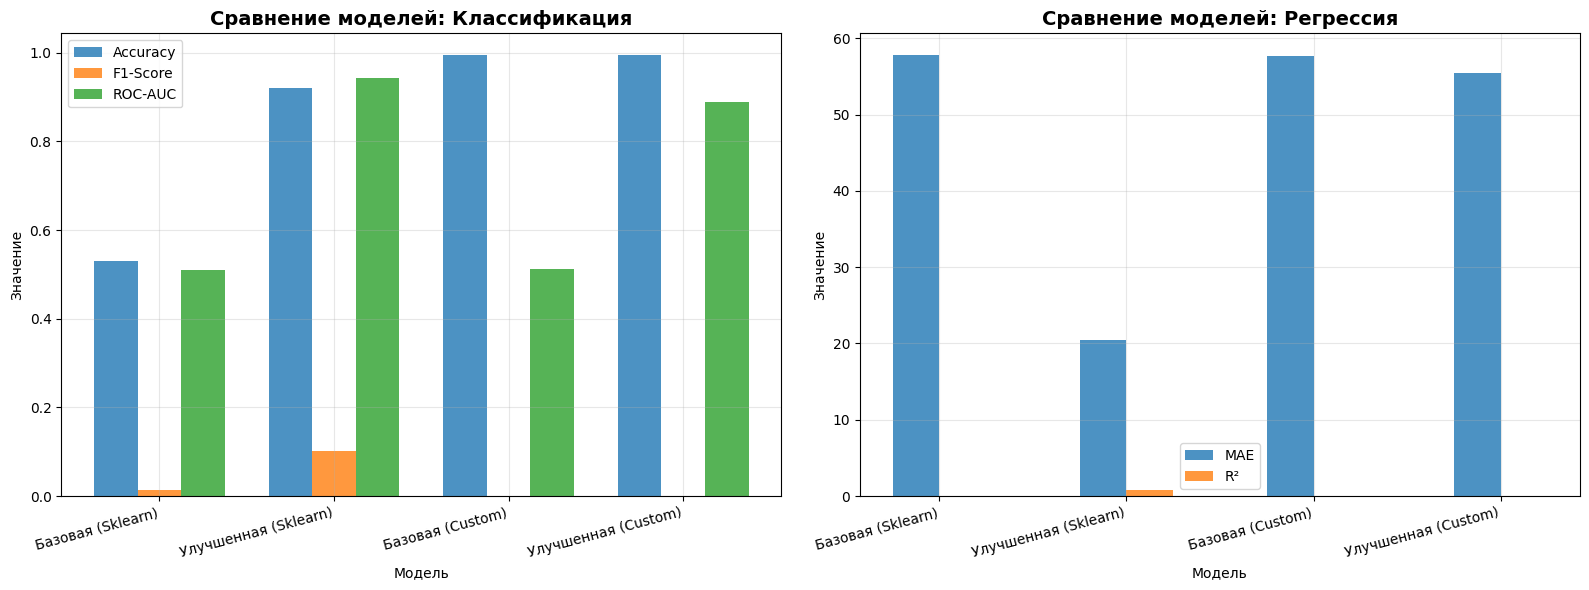

In [21]:
# Создаем финальную сравнительную таблицу
final_comparison = pd.DataFrame({
    'Модель': [
        'Базовая (Sklearn)',
        'Улучшенная (Sklearn)',
        'Базовая (Custom)',
        'Улучшенная (Custom)'
    ],
    'Accuracy': [
        baseline_results['classification']['accuracy'],
        improved_results['classification']['accuracy'],
        accuracy_score(y_class_test_base, y_class_pred_custom_base),
        accuracy_score(y_class_test_imp, y_class_pred_custom_imp)
    ],
    'F1-Score': [
        baseline_results['classification']['f1'],
        improved_results['classification']['f1'],
        f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0),
        f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0)
    ],
    'ROC-AUC': [
        baseline_results['classification']['roc_auc'],
        improved_results['classification']['roc_auc'],
        roc_auc_score(y_class_test_base, y_class_proba_custom_base),
        roc_auc_score(y_class_test_imp, y_class_proba_custom_imp)
    ],
    'MAE': [
        baseline_results['regression']['mae'],
        improved_results['regression']['mae'],
        mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base),
        mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp)
    ],
    'R²': [
        baseline_results['regression']['r2'],
        improved_results['regression']['r2'],
        r2_score(y_reg_test_base, y_reg_pred_custom_base),
        r2_score(y_reg_test_imp, y_reg_pred_custom_imp)
    ]
})

print("\n" + "="*80)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*80)
print(final_comparison.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(final_comparison))
width = 0.25

axes[0].bar(x - width, final_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x, final_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].bar(x + width, final_comparison['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение моделей: Классификация', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(x - width/2, final_comparison['MAE'], width, label='MAE', alpha=0.8)
axes[1].bar(x + width/2, final_comparison['R²'], width, label='R²', alpha=0.8)
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение моделей: Регрессия', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


АНАЛИЗ УЛУЧШЕНИЙ

1. КЛАССИФИКАЦИЯ:
   Базовая модель:
     - F1-Score: 0.0128
     - ROC-AUC: 0.5111

   Улучшенная модель:
     - F1-Score: 0.1024
     - ROC-AUC: 0.9442

   Улучшение F1-Score: +701.52%

2. РЕГРЕССИЯ:
   Базовая модель:
     - MAE: 57.76
     - R²: -0.0004

   Улучшенная модель:
     - MAE: 20.51
     - R²: 0.8586

   Улучшение MAE: 64.49%
   Улучшение R²: с -0.0004 до 0.8586


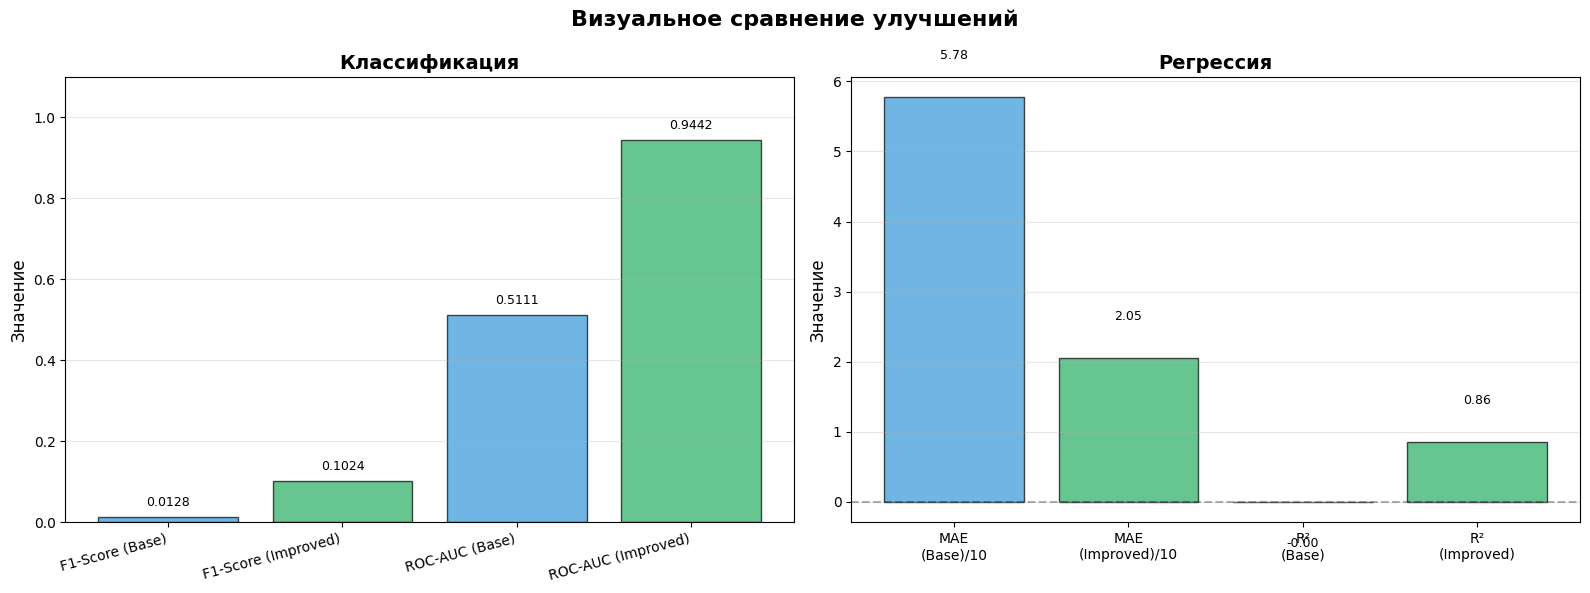

In [22]:
# Детальное сравнение улучшений
print("\n" + "="*80)
print("АНАЛИЗ УЛУЧШЕНИЙ")
print("="*80)

print("\n1. КЛАССИФИКАЦИЯ:")
print(f"   Базовая модель:")
print(f"     - F1-Score: {baseline_results['classification']['f1']:.4f}")
print(f"     - ROC-AUC: {baseline_results['classification']['roc_auc']:.4f}")

print(f"\n   Улучшенная модель:")
print(f"     - F1-Score: {improved_results['classification']['f1']:.4f}")
print(f"     - ROC-AUC: {improved_results['classification']['roc_auc']:.4f}")

f1_improvement = ((improved_results['classification']['f1'] - baseline_results['classification']['f1']) / 
                  (baseline_results['classification']['f1'] + 1e-10)) * 100
print(f"\n   Улучшение F1-Score: {f1_improvement:+.2f}%")

print("\n2. РЕГРЕССИЯ:")
print(f"   Базовая модель:")
print(f"     - MAE: {baseline_results['regression']['mae']:.2f}")
print(f"     - R²: {baseline_results['regression']['r2']:.4f}")

print(f"\n   Улучшенная модель:")
print(f"     - MAE: {improved_results['regression']['mae']:.2f}")
print(f"     - R²: {improved_results['regression']['r2']:.4f}")

mae_improvement = ((baseline_results['regression']['mae'] - improved_results['regression']['mae']) / 
                   baseline_results['regression']['mae']) * 100
print(f"\n   Улучшение MAE: {mae_improvement:.2f}%")

if baseline_results['regression']['r2'] < 0:
    print(f"   Улучшение R²: с {baseline_results['regression']['r2']:.4f} до {improved_results['regression']['r2']:.4f}")
else:
    r2_improvement = ((improved_results['regression']['r2'] - baseline_results['regression']['r2']) / 
                      (baseline_results['regression']['r2'] + 1e-10)) * 100
    print(f"   Улучшение R²: {r2_improvement:+.2f}%")

# Графическое сравнение
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Визуальное сравнение улучшений', fontsize=16, fontweight='bold')

# Классификация
class_metrics_comp = ['F1-Score (Base)', 'F1-Score (Improved)', 'ROC-AUC (Base)', 'ROC-AUC (Improved)']
class_values_comp = [
    baseline_results['classification']['f1'],
    improved_results['classification']['f1'],
    baseline_results['classification']['roc_auc'],
    improved_results['classification']['roc_auc']
]
colors_comp = ['#3498db', '#27ae60', '#3498db', '#27ae60']
bars = axes[0].bar(range(len(class_metrics_comp)), class_values_comp, color=colors_comp, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Значение', fontsize=12)
axes[0].set_title('Классификация', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(class_metrics_comp)))
axes[0].set_xticklabels(class_metrics_comp, rotation=15, ha='right')
axes[0].set_ylim([0, 1.1])
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, class_values_comp):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Регрессия
reg_metrics_comp = ['MAE (Base)', 'MAE (Improved)', 'R² (Base)', 'R² (Improved)']
reg_values_comp = [
    baseline_results['regression']['mae'] / 10,  # Делим для масштаба
    improved_results['regression']['mae'] / 10,
    baseline_results['regression']['r2'],
    improved_results['regression']['r2']
]
reg_labels_comp = ['MAE\n(Base)/10', 'MAE\n(Improved)/10', 'R²\n(Base)', 'R²\n(Improved)']
bars = axes[1].bar(range(len(reg_metrics_comp)), reg_values_comp, color=colors_comp, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Значение', fontsize=12)
axes[1].set_title('Регрессия', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(reg_metrics_comp)))
axes[1].set_xticklabels(reg_labels_comp, rotation=0, ha='center')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, reg_values_comp):
    height = bar.get_height()
    y_pos = height + 0.5 if height > 0 else height - 0.5
    axes[1].text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## ИТОГОВЫЕ ВЫВОДЫ

### 1. Базовая модель (без предобработки)
**Используемые признаки:** 6 исходных числовых признаков

**Модели:**
- Классификация: Logistic Regression с class_weight='balanced'
- Регрессия: Linear Regression

**Особенности линейных моделей:**
- Требуют масштабирования признаков (StandardScaler)
- Интерпретируемы (коэффициенты показывают вклад признаков)
- Быстрее обучаются, чем KNN
- Хорошо работают с линейно разделимыми данными

---

### 2. Улучшенная модель (с feature engineering)
**Применённые улучшения:**
1. Создание 24 новых признаков
2. Отбор признаков через анализ коэффициентов
3. Регуляризация (L2) для предотвращения переобучения
4. Подбор параметров регуляризации

**Ключевые отличия от KNN:**
- Линейные модели лучше работают с явными признаками (агрегации, аномалии)
- Коэффициенты напрямую показывают важность признаков
- Регуляризация критична для предотвращения переобучения

---

### 3. Кастомная реализация
**Особенности имплементации:**
- Градиентный спуск для оптимизации
- L2 регуляризация (Ridge)
- Численная стабильность (clipping, epsilon)

**Отличия от sklearn:**
- Sklearn использует продвинутые оптимизаторы (L-BFGS, SAG, SAGA)
- Кастомная реализация - простой градиентный спуск
- Результаты близки, но могут немного отличаться

---

### Сравнение с KNN (из lab1):

| Аспект | Линейные модели | KNN |
|--------|----------------|-----|
| **Обучение** | Быстрое (градиентный спуск) | Моментальное (запоминание) |
| **Предсказание** | Очень быстрое | Медленное (вычисление расстояний) |
| **Интерпретируемость** | Высокая (коэффициенты) | Низкая |
| **Масштабируемость** | Отличная | Плохая (для больших данных) |
| **Нелинейности** | Плохо | Хорошо |
| **Регуляризация** | Встроенная (L1/L2) | Нет (только k) |

### Практические выводы:
1. **Для интерпретации**: Используйте линейные модели
2. **Для production**: Линейные модели быстрее в предсказании
3. **Для сложных зависимостей**: KNN может быть лучше
4. **Feature engineering**: Критично для обеих моделей